In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#команда, которая указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline

from comet_ml import Experiment

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
#@title CometML set up
project_name = 'predict-income'
workspace = 'ketrint'
api_key = ''

In [3]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key  is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/python-sdk/warnings-errors/
COMET ERROR: The given API key  is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/python-sdk/warnings-errors/


In [7]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [8]:
training_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


In [10]:
test_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,27,Private,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,38,United-States,0
1,45,State-gov,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40,United-States,0
2,29,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,NaN,55,United-States,1
3,30,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,40,United-States,0
4,29,Self-emp-not-inc,Some-college,Divorced,Craft-repair,Not-in-family,White,Male,2202.0,0.0,50,United-States,0


In [9]:
#проверяем размерность файлов
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

In [11]:
#задаем целевую переменную
target_name = 'income'

In [12]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

In [13]:
#Оцениваем сбалансированности выборки
y_train.value_counts(normalize=True)

0    0.757821
1    0.242179
Name: income, dtype: float64

In [14]:
#изучаем статистику по числовым данным
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


Таким образом имеющаяся выборка несбалансирована.

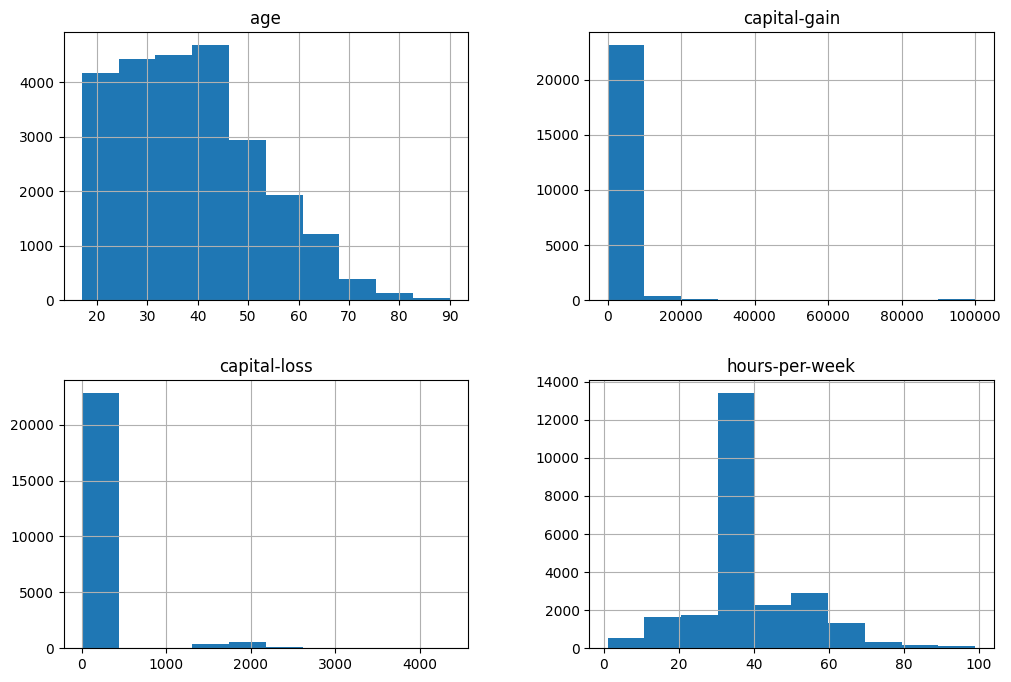

In [15]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Итого мы имеем:
* 8 признаков типа **object** - строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой.

Признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

**Важно:** тестовую выборку обрабатываем также, как и обучающую выборку.

In [17]:
#заполняем пропуски нулями
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)
#cделаем то же самое для тестовой выборки
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [21]:
X_train['workclass'].value_counts(True).head(1)

Private    0.696766
Name: workclass, dtype: float64

In [22]:
X_train['education'].value_counts(True).head(1)

HS-grad    0.322484
Name: education, dtype: float64

In [24]:
#заполним пропуски модой
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')
#cделаем то же самое для тестовой выборки
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

В данных 8 столбцов являются категориальными признаками. Эти признаки **текстовые**. Закоируем их. 

In [25]:
#Для начала выделим категорильные признаки:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

In [26]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


**Произведем кодировку с помощью Label Encoding**

In [28]:
label_encoder = LabelEncoder()

X_train_le = X_train.copy()
X_test_le = X_test.copy()

for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**Произведем кодировку с помощью One Hot Encoding**

In [30]:
onehot_encoder = OneHotEncoder()

#'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

#применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

#запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

In [31]:
#соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

#удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [32]:
X_train_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Обучаем модель на поразному закондированных данных**

In [34]:
linear_model_le = LogisticRegression()
linear_model_oh = LogisticRegression()

In [36]:
linear_model_oh.fit(X_train_new, y_train)

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [37]:
linear_model_le.fit(X_train_le, y_train)

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
prediction_oh = linear_model_oh.predict(X_test_new)
prediction_le = linear_model_le.predict(X_test_le)

**Оцениваем точность предсказания**

In [40]:
#Сравним значения точности для наших моделей с точностью для константного классификатора
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [41]:
acc_oh = accuracy_score(y_test, prediction_oh)
acc_le = accuracy_score(y_test, prediction_le)

In [44]:
experiment.log_metric('Accuracy OneHot data', acc_oh)
experiment.log_metric('Accuracy LE data', acc_le)

Построим таблицу сопряженности

In [46]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5785,429
1,812,1115


In [47]:
pd.DataFrame(confusion_matrix(y_test, prediction_le))

,0,1
0,5980,234
1,1356,571


In [48]:
experiment.log_confusion_matrix(y_test, prediction_oh)
experiment.log_confusion_matrix(y_test, prediction_le)

**Прогноз вероятности принадлежности к классу**

In [49]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)
pred_proba_le = linear_model_le.predict_proba(X_test_le)

In [50]:
pred_proba_oh_graph = pred_proba_oh[:, 1]
pred_proba_le_graph = pred_proba_le[:, 1]

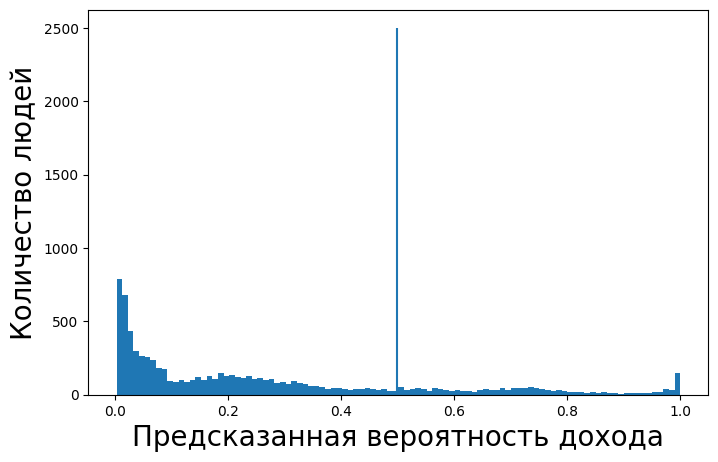

In [51]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba_oh_graph, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability_oh', plt)

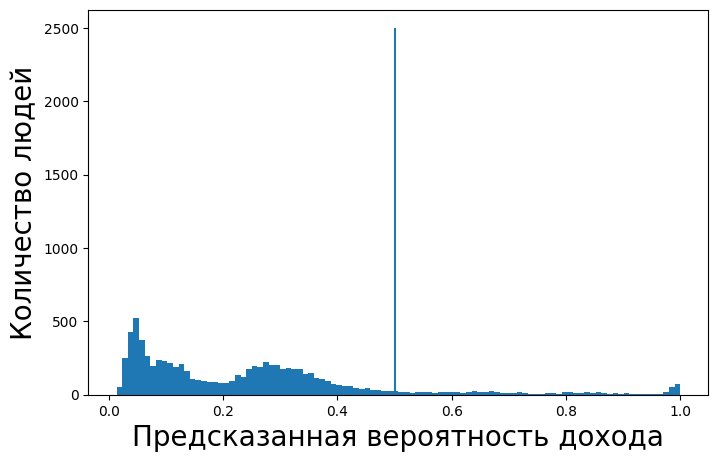

In [52]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba_le_graph, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability_le', plt)

**ROC кривая классификатора**

In [57]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba_oh_graph)

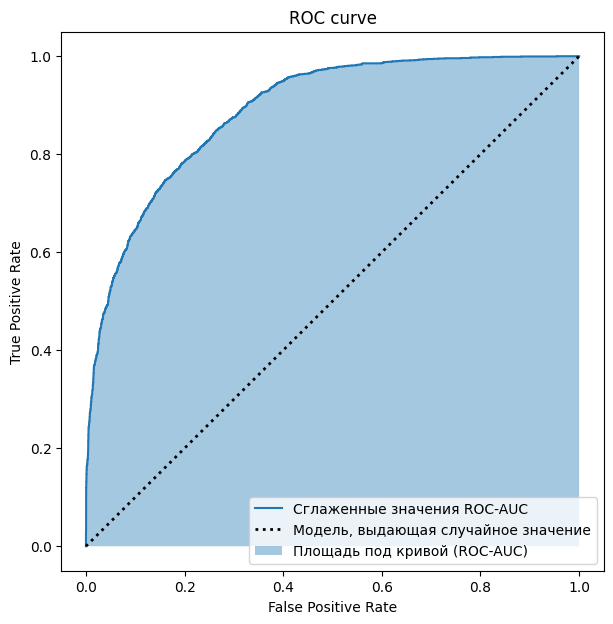

In [58]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [59]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba_le_graph)

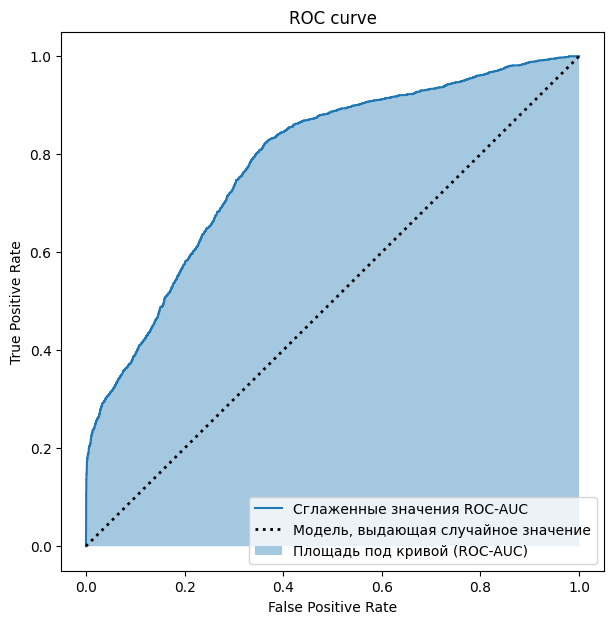

In [60]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [63]:
roc_auc_oh = roc_auc_score(y_test, pred_proba_oh_graph).round(3)
print("ROC-AUC на тестовой выборке:", roc_auc_oh)

ROC-AUC на тестовой выборке: 0.89


In [64]:
roc_auc_le = roc_auc_score(y_test, pred_proba_le_graph).round(3)
print("ROC-AUC на тестовой выборке:", roc_auc_le)

ROC-AUC на тестовой выборке: 0.785


In [65]:
experiment.log_metric('roc_auc OneHot data', roc_auc_oh)
experiment.log_metric('roc_auc LE data', roc_auc_le)

In [66]:
experiment.display()

In [67]:
experiment.end()